# MuJoCo Robotic Simulation Generating Synthetic Data
* Franka-Emika Panda

## Import packages

In [ ]:
%env MUJOCO_GL = egl
%matplotlib widget
import os
import pickle
from multiprocessing import Lock, Pool
from xml.etree import ElementTree as et

import matplotlib.pyplot as plt
import mediapy as media
import numpy as np

# Access to enums and MuJoCo library functions.
from dm_control import mujoco
from dm_control.mujoco.wrapper.mjbindings import mjlib
from dm_control.utils import inverse_kinematics as ik
from IPython.display import HTML, clear_output, display
from PIL import Image
from scipy.spatial.transform import Rotation as R
from scipy.special import gamma

# Rendering parameters
dpi = 100
framerate = 30  # (Hz)
width, height = 1280, 720

# IK solver parameters
_MAX_STEPS = 100
_TOL = 1e-12

# Scene XML
robot_xml = "../models/panda_nohand.xml"
scene_xml = "../models/scene.xml"
site_name = "attachment_site"
reach_sites = ["sharp_site", "round_site", "wedge_site"]
actuator_id = {"sharp_site": 1, "round_site": 2, "wedge_site": 3}
joint_names = ["joint{}".format(i + 1) for i in range(7)]

# Multiprocessing lock
threaded = False
if threaded:
    lock = Lock()

env: MUJOCO_GL=egl


## [Optional]Update The Scene XML File
* [Mujoco XML Reference](https://mujoco.readthedocs.io/en/latest/XMLreference.html?highlight=site#body-site)
* [The ElementTree XML API](https://docs.python.org/3/library/xml.etree.elementtree.html)

### Tactile Sensor

1. Sensor Pad 
* for visual only

2. Collision Balls (mono-layer)
* _M: (x-count, y-count)
* geom_type: [sphere, capsule, ellipsoid, cylinder, box], “sphere”
* dx: the distance between each site
* offset: uniform distance to shift all sites

3. Slide Joints
* connect the balls to the pad
* joint positions serve as sensory values
* small time constant

4. Tendons to Connect Balls
* planar spring connection
* creates contact-force distribution

### Key Frames
* Initial poses

In [ ]:
def reset(parent, child_name):
    child = parent.find(child_name)
    if child is not None:
        parent.remove(child)
    return et.SubElement(parent, child_name)


def create_element(name, attrs: dict):
    elem = et.Element(name)
    for k, v in attrs.items():
        if not isinstance(v, str):
            v = str(v)
        elem.set(k, v)
    return elem


# Define 3D arrays of balls connected with sliders
_M = (15, 15)
radius = 5e-4
mass = 1e-6 / np.prod(_M)
dx = (3e-2 - 2 * radius) / (_M[0] - 1)
offset = dx * (_M[0] - 1) / 2.0
geom_type = "sphere"

tree = et.parse(robot_xml)
root = tree.getroot()
for body in root.findall(".//body"):
    if body.get("name") == "sensor_pad":
        sensor_body = body
        for e in body.findall("body"):
            body.remove(e)

tendons = reset(root, "tendon")
sensors = reset(root, "sensor")


def create_composite(sid, pos, euler, springdamper=(2, 1)):
    body = create_element(
        "body",
        {
            "name": "taxel{:d}".format(sid),
            "pos": "{:.6f} {:.6f} {:.6f}".format(pos[0], pos[1], pos[2]),
            "euler": euler,
        },
    )
    inertia = create_element(
        "inertial",
        {
            "mass": "{:.6e}".format(mass),
            "fullinertia": "{} {} {} 0 0 0".format(mass, mass, mass),
            "pos": "0 0 0",
        },
    )
    ballJoint = create_element(
        "joint",
        {
            "name": "ball_joint{}".format(sid),
            "type": "ball",
            "pos": "0 0 2e-3",
            "range": "0 3.14159265",
            "group": 0,
        },
    )
    slideJoint = create_element(
        "joint",
        {
            "name": "slide_joint{}".format(sid),
            "type": "slide",
            "axis": "0 0 1",
            "springdamper": "{} {}".format(springdamper[0], springdamper[1]),
            "frictionloss": "1e-12",
            "group": 1,
        },
    )
    geom = create_element(
        "geom",
        {
            "name": "ball{:d}".format(sid),
            "type": geom_type,
            "size": radius,
            "class": "collision",
            "group": 3,
        },
    )
    site = create_element(
        "site",
        {
            "name": "touch_site{}".format(sid),
            "type": "capsule",
            "size": "{} {}".format(radius, 2 * radius),
            "group": 1,
        },
    )

    body.append(inertia)
    # body.append(ballJoint)
    body.append(slideJoint)
    body.append(geom)
    body.append(site)
    return body


# Define balls with sliders and touch sensors
sid = 0
for i in range(_M[0]):
    for j in range(_M[1]):
        sid += 1
        parent = create_composite(
            sid, (dx * i - offset, dx * j - offset, 1e-3), "0 0 0", (2e-3, 0.9)
        )
        sensor_body.append(parent)
        touch_sensor = et.SubElement(
            sensors, "touch".format(sid), {"site": "touch_site{}".format(sid)}
        )

tree.write(robot_xml)  # Save robot XML

# Modify the keyframe home key qpos
njoints = np.prod(_M) + 10
tree = et.parse(scene_xml)
root = tree.getroot()
key = root.find(".//keyframe/key")
qpos_value = "0 0 0 {} 0 {} 0.785398 0 0 0".format(
    -0.5 * np.pi, 0.5 * np.pi, 0.25 * np.pi
)
key.attrib["ctrl"] = qpos_value
if njoints > 10:
    qpos_value += " " + " ".join(["0" for i in range(njoints - 10)])
key.attrib["qpos"] = qpos_value
tree.write(scene_xml)

# XML testing
physics = mujoco.Physics.from_xml_path(scene_xml)
physics.reset(0)
pixels = physics.render(camera_id="prospective", width=width, height=height)
Image.fromarray(pixels)

## Robotic Simulation for Tactile Encoding Test

* Synthetic data generation
    - Check [models](../models/platform.xml) for edge types
* Save sensor data and simulation
    - [Sensordata](touch3edge.pkl)

In [ ]:
def gen_dataset(
    scene_xml, site_name, target_name, joint_names, duration=2.0, rendered=True
):
    physics = mujoco.Physics.from_xml_path(scene_xml)
    physics.reset(0)

    omega = 4 * np.pi / duration * np.array([1, 1, 1])
    ctrl = np.empty(10)
    video = []
    stream = []
    orientations = []
    control_site = physics.data.site(name=site_name)
    target_site = physics.data.site(name=target_name)
    target_quat = R.from_matrix(control_site.xmat.reshape((3, 3))).as_quat()
    target_xpos = target_site.xpos.copy()
    target_xpos[2] -= 1e-3
    smooth_factor = 0.5

    # Simulate, saving video frames
    while physics.data.time <= duration:
        move_vec = (
            (target_xpos - control_site.xpos)
            * min(smooth_factor, physics.data.time)
            / smooth_factor
        )
        # Compute the inverse kinematics
        if np.linalg.norm(control_site.xpos - target_xpos) > _TOL:
            result = ik.qpos_from_site_pose(
                physics,
                site_name,
                target_pos=control_site.xpos + move_vec,
                target_quat=target_quat,
                joint_names=joint_names,
                tol=_TOL,
                max_steps=_MAX_STEPS,
                inplace=False,
            )
            ctrl[:7] = result.qpos[:7]
        ctrl[-3:] = omega * physics.data.time
        physics.set_control(ctrl)
        physics.step()

        # Save sensordata when there is contact
        if len(physics.data.contact) > 0:
            sensordata = physics.data.sensordata.copy()
            M = np.sqrt(sensordata.shape[0]).astype(int)
            data = sensordata.reshape(M, M)
            stream.append(data)
            oris = physics.named.data.qpos[
                "rotator_joint%d" % actuator_id[target_name]
            ].copy()
            orientations.append(oris)

        # Save video frames
        clear_output(wait=True)
        print(
            "PID {} simulating {}. Progress: {:.1f}%".format(
                os.getpid(), target_name, physics.data.time / duration * 100
            )
        )
        if rendered and len(video) < physics.data.time * framerate:
            if threaded:
                lock.acquire()
            pixels = physics.render(camera_id="prospective", width=width, height=height)
            if threaded:
                lock.release()
            video.append(pixels.copy())

    return target_name, video, stream, orientations


ds = dict()

for rs in reach_sites:
    label, video, stream, orientations = gen_dataset(
        scene_xml, site_name, rs, joint_names, duration=7.0, rendered=True
    )
    ds[label] = {"sensordata": stream, "orientations": orientations}
    media.write_video("../data/" + label + ".mp4", video, fps=30)

with open("../data/touch.pkl", "wb") as f:
    pickle.dump(ds, f)

## Visualize simulation

In [ ]:
from IPython.display import Video

Video(url="../docs/round_site.mp4", width=720)

## Visualize Tactile Signals
* $15 \times 15$ taxels simulated by damped spring-linked particles

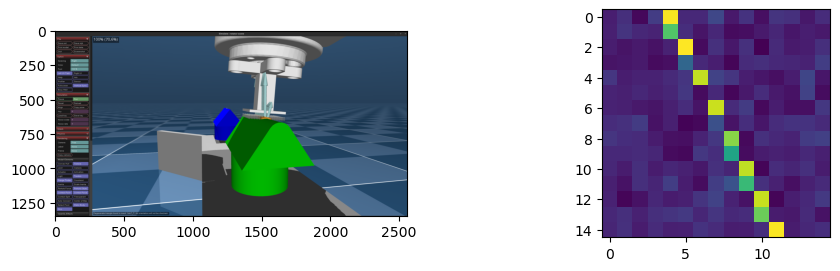

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
from TouchDataset import TouchDataset

dataset = TouchDataset("../data/touch.pkl", noise_scale=5e-2, flatten=False)
image = Image.open("../docs/soft_contact.png")
fig = plt.figure(figsize=(10, 5))
ax0 = plt.subplot(121)
ax0.imshow(image)
ax1 = plt.subplot(133)
ax1.imshow(dataset[1000][0])
plt.show()

# Unsupervised Edge Orientation Classifier
1. 3-Layer Layer Spiking Neural Network
2. Binary input layer
3. Random receptive field - 25 neurons
4. Edge Orientation Output - 36 neurons

## Define Network structure and hyper-parameters

In [1]:
import numpy as np
from brian2 import *

events = {
    "event3": ["increase_threshold", "v > v_th", "v_th += delta_theta+randn()*mV"]
}

params = {
    # Model constants
    "C_mem": 200 * pF,  # Membrane capacitance
    "delta_theta": 2 * mV,  # Adaptive threshold incremental scale
    "g_l": 10 * nS,  # Leak conductance
    "J_C": 1,  # Scale of the calcium variable
    "tau_c": 60 * ms,  # Calcium variable time constant
    "tau_e": 10 * ms,  # Excitatory synaptic time constant
    "tau_i": 10 * ms,  # Inhibitory synaptic time constant
    "tau_r": 5 * ms,  # Refractory period
    "tau_theta": 5 * ms,  # Adaptive threshold time constant
    "V_ir": -80 * mV,  # Inhibitory reverse potential
    "V_res": -65 * mV,  # Resting potential
    "V_theta": -55 * mV,  # Spiking threshold
    "w_e": 18 * nS,  # Excitatory conductance increment
    "w_i": 40 * nS,  # Inhibitory conductance increment
    "X_max": 1,  # Synaptic variable maximum
    "X_min": 0,  # Synaptic variable minimum
    # Simulation parameters
    "defaultclock.dt": 1 * ms,  # Time step
}

# Thresholds and plasticity parameters
params["a"] = 0.1 * params["X_max"]
params["b"] = 0.1 * params["X_max"]
params["alpha"] = 3.5 * params["X_max"] * Hz
params["beta"] = 3.5 * params["X_max"] * Hz
params["theta_hup"] = 12 * params["J_C"]
params["theta_lup"] = 3 * params["J_C"]
params["theta_hdown"] = 4 * params["J_C"]
params["theta_ldown"] = 3 * params["J_C"]
params["theta_v"] = 0.8 * params["V_theta"]
params["theta_X"] = 0.5 * params["X_max"]
params["learning_switch"] = 1

eqs = {
    # Neuronal models
    "L1": """
        dv/dt = (g_l*(V_res - v) + I(t,i))/C_mem : volt (unless refractory)
        x : 1
        y : 1
        """,
    "L2": """
        dv/dt = (g_l*(V_res - v) - g_e*v)/C_mem : volt (unless refractory)
        dg_e/dt = -g_e/tau_e : siemens
        sum_w : 1
        x : 1
        y : 1
        """,
    "L3": """
        dv/dt = (g_l*(V_res - v) - g_e*v + g_i*(V_ir - v))/C_mem : volt (unless refractory)
        dg_e/dt = -g_e/tau_e : siemens
        dg_i/dt = -g_i/tau_i : siemens
        dv_th/dt = (V_theta - v_th)/tau_theta : volt
        sum_w : 1
        """,
    # Synaptic models
    "Syn12": """
        w : 1
        sum_w_post = w : 1 (summed)
        """,
    "Syn23": """
        count : 1
        X_condition : 1
        dc/dt = -c/tau_c + J_C*count*Hz: 1 (clock-driven)
        dX/dt = (alpha*int(X > theta_X)*int(X < X_max) - beta*int(X <= theta_X)*int(X > X_min))*(1 - X_condition) : 1 (clock-driven)
        w = int(X >= 0.5) : 1
        sum_w_post = w : 1 (summed)
        """,
    # Synaptic events
    "Pre12": """
        g_e_post += w_e/sum_w_post
        """,
    "Pre23": """
        g_e_post += w*w_e/sum_w_post
        X += a*int(v_pre > theta_v)*int(theta_lup < c)*int(c < theta_hup) - b*int(v_pre <= theta_v)*int(theta_ldown < c)*int(c < theta_hdown)
        X = clip(X, X_min, X_max)
        X_condition = int(v_pre > theta_v)*int(theta_lup < c)*int(c < theta_hup) + int(v_pre <= theta_v)*int(theta_ldown < c)*int(c < theta_hdown)
        """,
    "Post23": """
        count += 1
        X_condition = 0
        """,
}

connections = {
    "Syn12": {"mode": "balanced_random"},
    "Syn23": {"mode": "full"},
}

recordings = {
    "L1": ["v"],
    "L2": ["v"],
    "L3": ["v"],
    "Syn23": ["X", "w"],
}

initial_values = {
    "L1": {"v": "V_res + rand()*(V_theta - V_res)"},
    "L2": {"v": "V_res + rand()*(V_theta - V_res)"},
    "L3": {
        "v": "V_res + rand()*(V_theta - V_res)",
        "v_th": "V_theta",
        "g_e": 0 * nS,
        "g_i": 0 * nS,
    },
    "Syn12": {"w": 1},
    "Syn23": {"count": 0, "c": 2, "X": "rand()*X_max", "delay": "rand()*tau_r"},
}


def generate_conns(N, M, mode="full"):
    """Generate connection patterns for the Synapses.

    Parameters
    ----------
        N : int
            Number of incoming synapses.
        M : int
            Number of outgoing synapses.
        mode : {'different', 'full', 'random'}, default='full'
            Connection mode.

    Returns
    -------
        i, j, condition, p: (int, int, str, float)
            Synaptic connection configs.

    """
    i, j = None, None
    condition = None
    p = 1.0

    match mode:
        case "different":
            condition = "i != j"
        case "full":
            i = np.repeat(np.arange(N), M)
            j = np.tile(np.arange(M), N)
        case "gaussian":
            p = "1.0 * exp(-((x_pre-x_post)**2 + (y_pre-y_post)**2)/(sqrt(2)*rf_size**2))"
        case "random":
            p = "rand()"
        case "balanced_random":
            i = np.arange(N)
            np.random.shuffle(i)
            j = np.zeros(N, dtype=int)
            j[0 : N // M * M] = np.repeat(np.arange(M), N // M)

    return i, j, condition, p


class TacNet(object):
    def __init__(
        self, num_neurons: list, stimuli, receptive_field="balanced_random"
    ) -> None:
        """Constructor of the Tactile Encoding Network.

        Parameters
        ----------
            num_neurons : list of int
                List of numbers of neurons of each layer. 'L1' is the input layer.
        """

        try:
            device.reinit()
            device.activate()
        except _:
            pass

        params["I"] = stimuli
        connections["Syn12"]["mode"] = receptive_field

        # Define NeuronGroups (layers)
        neuron_groups = {}
        for index, n_neuron in enumerate(num_neurons):
            layer_name = "L%d" % (index + 1)
            event_name = "event%d" % (index + 1)

            if event_name in events:
                event_label = events[event_name][0]
                event_trigger = events[event_name][1]
                event_operation = events[event_name][2]
                event = {event_label: event_trigger}
            else:
                event = None

            # Check v_th for adaptive thresholding
            threshold = "V_theta"
            if "threshold" in event_name:
                threshold = "v_th"

            neuron_groups[layer_name] = NeuronGroup(
                n_neuron,
                model=eqs[layer_name],
                method="euler",
                threshold="v > %s" % threshold,
                reset="v = V_res",
                refractory="tau_r",
                events=event,
                namespace=params,
                name=layer_name,
            )
            if event is not None:
                neuron_groups[layer_name].run_on_event(event_label, event_operation)

        # Assign coordinates to L1 neurons
        l1_size = sqrt(len(neuron_groups["L1"]))
        l2_size = sqrt(len(neuron_groups["L2"]))
        rf_size = l1_size / l2_size

        neuron_groups["L1"].x = "i // l1_size"
        neuron_groups["L1"].y = "i % l1_size"
        neuron_groups["L2"].x = "rf_size // 2 + rf_size * (i // l2_size)"
        neuron_groups["L2"].y = "rf_size // 2 + rf_size * (i % l2_size)"

        # Define Synapses
        synapses = {}
        for source in range(len(num_neurons)):
            for target in range(len(num_neurons)):
                link = "%d%d" % (source + 1, target + 1)
                syn_name = "Syn" + link
                pre_name = "Pre" + link
                post_name = "Post" + link
                if syn_name in eqs:
                    if pre_name in eqs:
                        on_pre = eqs[pre_name]
                    else:
                        on_pre = None
                    if post_name in eqs:
                        on_post = eqs[post_name]
                    else:
                        on_post = None
                    synapses[syn_name] = Synapses(
                        neuron_groups["L%d" % (source + 1)],
                        neuron_groups["L%d" % (target + 1)],
                        model=eqs[syn_name],
                        on_pre=on_pre,
                        on_post=on_post,
                        namespace=params,
                        method="euler",
                        name=syn_name,
                    )

        # Connect synapses
        for synapse in synapses.values():
            mode = connections[synapse.name]["mode"]
            source, target, condition, p = generate_conns(
                synapse.source.N, synapse.target.N, mode=mode
            )
            synapse.connect(i=source, j=target, condition=condition, p=p)

        # Define Monitors
        self.mons = dict()
        for layer in neuron_groups.values():
            mon_name = "SpikeMonitor_" + layer.name
            self.mons[mon_name] = SpikeMonitor(layer, record=True, name=mon_name)
        for k, v in recordings.items():
            mon_name = "StateMonitor_" + k
            if k in neuron_groups:
                G = neuron_groups[k]
                record = True
            if k in synapses:
                G = synapses[k]
                record = np.arange(G.source.N * G.target.N)
            if "G" in locals():
                self.mons[mon_name] = StateMonitor(G, v, record=record, name=mon_name)

        # Add all groups to the network
        self.net = Network()
        for layer in neuron_groups.values():
            self.net.add(layer)
        for synapse in synapses.values():
            self.net.add(synapse)
        for monitor in self.mons.values():
            self.net.add(monitor)

        self.initiate(initial_values)

    def initiate(self, initial_values: dict):
        """Set initial values for the simulator.

        Parameters
            initial_values (dict): _description_
        """
        for k, iv_dict in initial_values.items():
            for attr, iv in iv_dict.items():
                if k in self.net:
                    setattr(self.net[k], attr, iv)

    def run(self, duration, save_state=None):
        """Run the simulation for a duration and save the state(optional).

        Parameters
            duration (Quantity): Time to run the simulation.
            save_state (str): Filepath to save the state. Defaults to None.

        Returns
            dict: A dictionary of Monitors.
        """
        self.net.run(duration=duration)
        return self.mons

## Brian2 Simulation

In [6]:
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
from brian2tools import brian_plot, plot_state
from TouchDataset import TouchDataset

matplotlib.rcParams.update({"font.size": 20})

# prefs.devices.cpp_standalone.openmp_threads = 3
set_device("cpp_standalone")


def wrap2deg(rad):
    theta = np.array(rad)
    theta = theta.reshape(-1)
    n = np.floor(theta / np.pi)
    return (theta - n * np.pi) / np.pi * 180


# Prepare dataset
dataset = TouchDataset(filepath="../data/touch.pkl", noise_scale=0.02, scope=(0.0, 1.0))
subset = dataset.subset(tags=["round_site"])
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.1, shuffle=True)


# Augment data
time_step = params["defaultclock.dt"]
presentation_time = 20*ms
n = int(presentation_time / time_step)  # repetition per stimulus
samples, orientations = np.repeat(X_train, n, axis=0), np.repeat(y_train, n, axis=0)

# Prepare simulation
# Convert values to spikes
duration = len(samples) * ms
length, height, width = samples.shape
inputs = samples.reshape(length, -1)
inputs[inputs > inputs.mean()] = 1
inputs[inputs < 1] = 0

I = TimedArray(inputs * 200 * pA, dt=time_step)
num_neurons = [height * width, 36, 36]
model = TacNet(num_neurons, I, receptive_field="balanced_random")
total_time = I.values.shape[0] * time_step
mons = model.run(duration)
print("Simulation Done.")

Simulation Done.


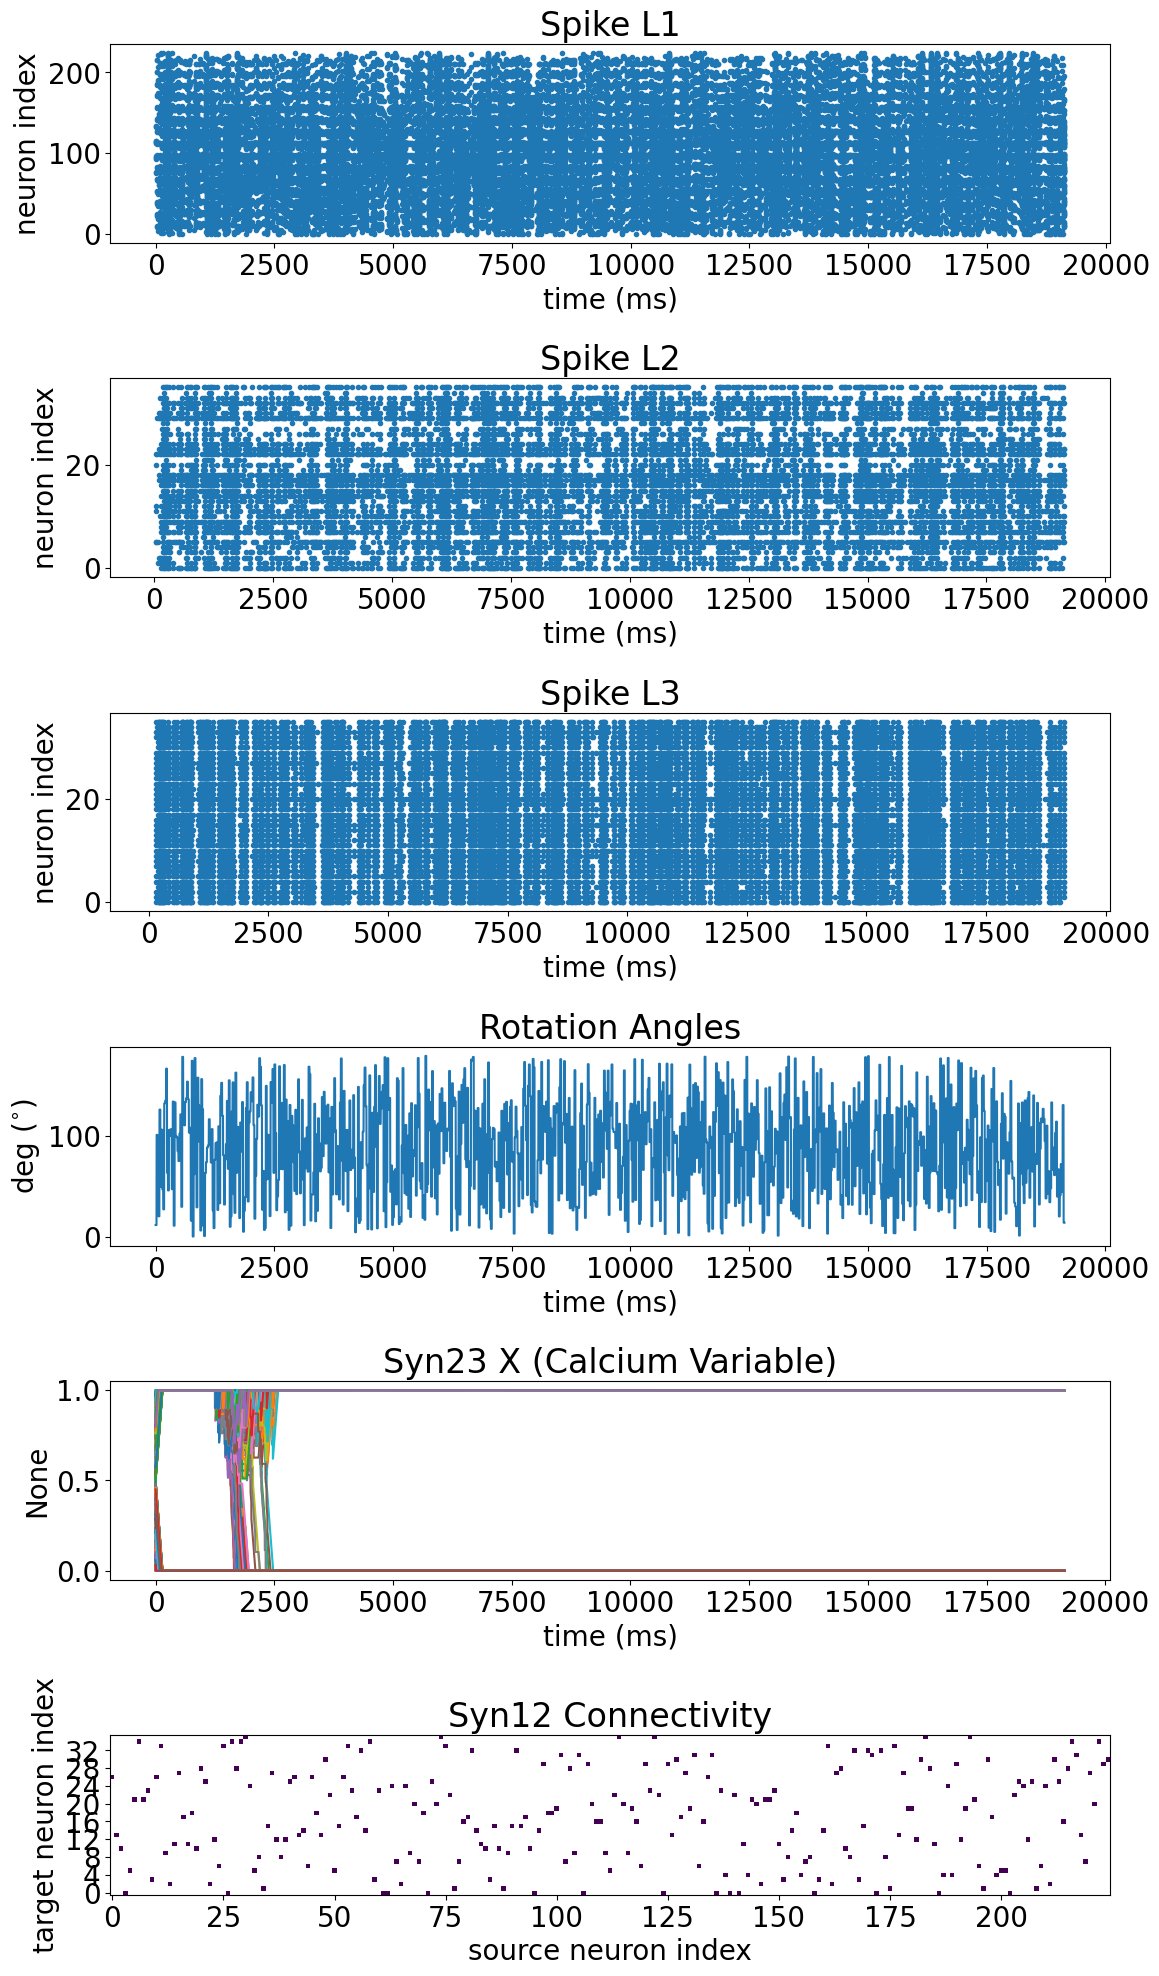

In [7]:
# Plot results
layers = [1, 2, 3]
nlayers = len(layers)

fig, axs = plt.subplots(nlayers + 3, 1, figsize=(12, 20))
for i, layer in enumerate(layers):
    axs[i].set_title("Spike L" + str(layer))
    brian_plot(mons["SpikeMonitor_L" + str(layer)], axes=axs[i])

axs[nlayers].plot(wrap2deg(orientations[: int(duration / time_step)]))
axs[nlayers].set_title("Rotation Angles")
axs[nlayers].set_xlabel("time (ms)")
axs[nlayers].set_ylabel(r"deg ($^{\circ}$)")
axs[nlayers + 1].set_title("Syn23 X (Calcium Variable)")
plot_state(
    mons["StateMonitor_Syn23"].t, mons["StateMonitor_Syn23"].X.T, axes=axs[nlayers + 1]
)
axs[nlayers + 2].set_title("Syn12 Connectivity")
brian_plot(model.net["Syn12"], axes=axs[nlayers + 2])
plt.tight_layout()

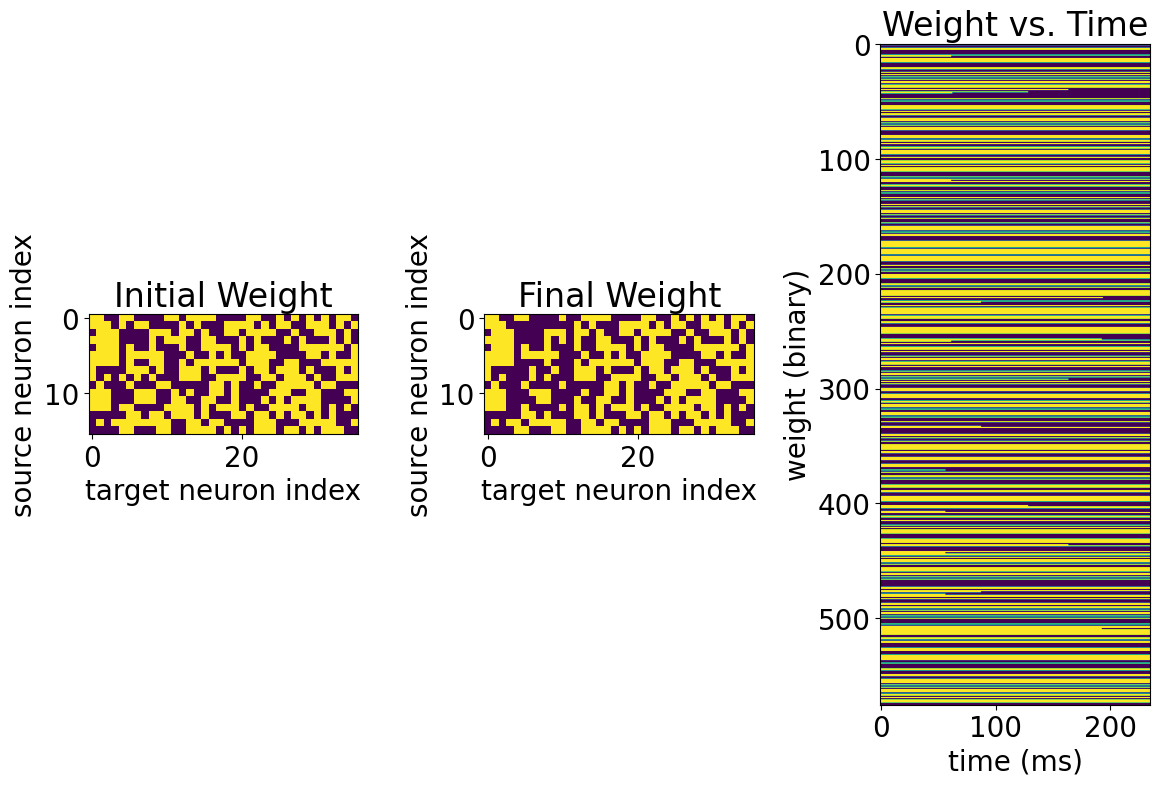

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 10))
axes[0].imshow(
    mons["StateMonitor_Syn23"].w_[:, 0].reshape((num_neurons[1], num_neurons[2]))
)
axes[0].set_title("Initial Weight")
axes[1].imshow(
    mons["StateMonitor_Syn23"].w_[:, -1].reshape((num_neurons[1], num_neurons[2]))
)
axes[1].set_title("Final Weight")
for i in range(2):
    axes[i].set_xlabel("target neuron index")
    axes[i].set_ylabel("source neuron index")
axes[2].imshow(mons["StateMonitor_Syn23"].w_[:, 0:-1:1000].reshape((num_neurons[1]*num_neurons[2], -1)))
axes[2].set_title("Weight vs. Time")
axes[2].set_xlabel("time (ms)")
axes[2].set_ylabel("weight (binary)")
plt.tight_layout()
plt.show()

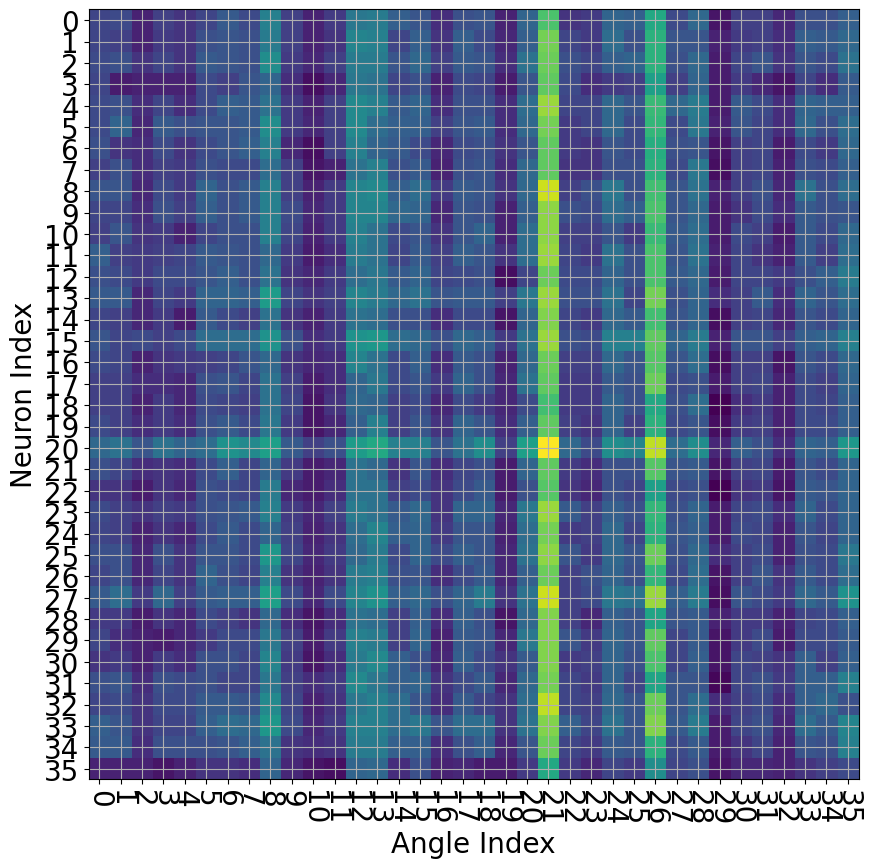

In [8]:
matplotlib.rcParams.update({"font.size": 20})

delta_deg = 180 / 36
matrix = np.zeros((36, 36))
for nid, strain in mons["SpikeMonitor_L3"].spike_trains().items():
    if len(strain) > 0:
        indices = np.floor(strain / presentation_time).astype(int)
        rads = [y_train[index, 0] for index in indices]
        out = np.floor(wrap2deg(rads) / delta_deg).astype(int)
        for m in out:
            matrix[nid, m] += 1
plt.figure(figsize=(10, 10))
plt.imshow(matrix)
plt.ylabel("Neuron Index")
plt.xlabel("Angle Index")
plt.xticks(np.arange(36), rotation=-90)
plt.yticks(np.arange(36))
plt.grid()
plt.show()

# Reference
[1] A. Parvizi-Fard, M. Amiri, D. Kumar, M. M. Iskarous, and N. V. Thakor, “A functional spiking neuronal network for tactile sensing pathway to process edge orientation,” Sci Rep, vol. 11, no. 1, p. 1320, Dec. 2021, doi: 10.1038/s41598-020-80132-4.

[2] X. She, S. Dash, D. Kim, and S. Mukhopadhyay, “A Heterogeneous Spiking Neural Network for Unsupervised Learning of Spatiotemporal Patterns,” Front. Neurosci., vol. 14, p. 615756, Jan. 2021, doi: 10.3389/fnins.2020.615756.

[3] J. A. Pruszynski and R. S. Johansson, “Edge-orientation processing in first-order tactile neurons,” Nat Neurosci, vol. 17, no. 10, pp. 1404–1409, Oct. 2014, doi: 10.1038/nn.3804.

[4] J. A. Pruszynski, J. R. Flanagan, and R. S. Johansson, “Fast and accurate edge orientation processing during object manipulation,” eLife, vol. 7, p. e31200, Apr. 2018, doi: 10.7554/eLife.31200.

[5] J. Platkiewicz, “Haptic Edge Detection Through Shear,” Scientific Reports, p. 10.

[6] J. M. Brader, W. Senn, and S. Fusi, “Learning Real-World Stimuli in a Neural Network with Spike-Driven Synaptic Dynamics,” Neural Computation, vol. 19, no. 11, pp. 2881–2912, Nov. 2007, doi: 10.1162/neco.2007.19.11.2881.

[7] T. Barbier, C. Teuliere, and J. Triesch, “Spike timing-based unsupervised learning of orientation, disparity, and motion representations in a spiking neural network,” in 2021 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), Nashville, TN, USA, Jun. 2021, pp. 1377–1386. doi: 10.1109/CVPRW53098.2021.00152.